# ERA5 single-location smoke test
Quick notebook to check Earth Engine pulls for 1-hour and 10-hour windows at a single location.
Set your coordinates and start time below, then run the fetch cell.


In [1]:
import os
import pandas as pd
import ee
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize Earth Engine (uses EE_PROJECT if set)
def init_ee():
    project = os.environ.get("EE_PROJECT")
    if project:
        ee.Initialize(project=project)
        print(f"Initialized Earth Engine with project: {project}")
    else:
        ee.Initialize()
        print("Initialized Earth Engine with default credentials/project")

def add_wind_speed(image):
    u = image.select('u_component_of_wind_100m')
    v = image.select('v_component_of_wind_100m')
    ws = u.hypot(v).rename('wind_speed_100m')
    return image.addBands(ws).copyProperties(image, image.propertyNames())

def fetch_era5_slice(lat, lon, start_iso, hours):
    # Pull a small ERA5 slice and return a sorted DataFrame.
    start = pd.to_datetime(start_iso, utc=True)
    end = start + pd.to_timedelta(hours, unit="h")
    point = ee.Geometry.Point([lon, lat])

    coll = (
        ee.ImageCollection("ECMWF/ERA5/HOURLY")
        .filterBounds(point)
        .filterDate(start.isoformat(), end.isoformat())
        .select(["u_component_of_wind_100m", "v_component_of_wind_100m"])
        .map(add_wind_speed)
        .select(["u_component_of_wind_100m", "v_component_of_wind_100m", "wind_speed_100m"])
    )

    # Pull data for the point; this is small (<= 10 hours)
    data = coll.getRegion(point, 27000).getInfo()
    if len(data) <= 1:
        return pd.DataFrame()

    header, rows = data[0], data[1:]
    df = pd.DataFrame(rows, columns=header)
    df["datetime"] = pd.to_datetime(df["time"], unit="ms", utc=True)
    keep = [
        c
        for c in [
            "datetime",
            "longitude",
            "latitude",
            "u_component_of_wind_100m",
            "v_component_of_wind_100m",
            "wind_speed_100m",
        ]
        if c in df.columns
    ]
    return df[keep].sort_values("datetime").reset_index(drop=True)

def fetch_era5_range_chunked(lat, lon, start_iso, hours, chunk_hours=2000, parallel=False, max_workers=None):
    """Chunked fetch to avoid large getInfo payloads; optionally parallelize chunk downloads."""
    start = pd.to_datetime(start_iso, utc=True)
    end = start + pd.to_timedelta(hours, unit="h")
    chunk_delta = pd.to_timedelta(chunk_hours, unit="h")

    chunks = []
    cursor = start
    idx = 0
    while cursor < end:
        next_cursor = cursor + chunk_delta
        if next_cursor > end:
            next_cursor = end
        chunk_hours_actual = (next_cursor - cursor) / pd.Timedelta(hours=1)
        chunks.append((idx, cursor.isoformat(), chunk_hours_actual))
        cursor = next_cursor
        idx += 1

    if not chunks:
        return pd.DataFrame()

    def fetch_one(chunk_meta):
        chunk_idx, chunk_start, chunk_hours_actual = chunk_meta
        df_chunk = fetch_era5_slice(lat, lon, chunk_start, chunk_hours_actual)
        return chunk_idx, df_chunk

    frames = [None] * len(chunks)
    if parallel and len(chunks) > 1:
        workers = min(max_workers or len(chunks), len(chunks))
        with ThreadPoolExecutor(max_workers=workers) as executor:
            future_map = {executor.submit(fetch_one, chunk): chunk for chunk in chunks}
            for future in as_completed(future_map):
                chunk_idx, df_chunk = future.result()
                frames[chunk_idx] = df_chunk
    else:
        for chunk in chunks:
            chunk_idx, df_chunk = fetch_one(chunk)
            frames[chunk_idx] = df_chunk

    frames = [f for f in frames if f is not None and not f.empty]
    if not frames:
        return pd.DataFrame()

    return pd.concat(frames, ignore_index=True).sort_values("datetime").reset_index(drop=True)


In [2]:
# --- Set your test location and window ---
LAT = 39.7392   # Denver, CO
LON = -104.9903
START_ISO = "2023-01-15T00:00:00Z"  # UTC ISO8601 string
HOURS_SHORT = 10
HOURS_LONG = 8760


Set `PARALLEL_CHUNKS = True` to pull all five ~2k-hour chunks concurrently (bounded by `CHUNK_WORKERS`).


In [16]:
import time

MAX_CHUNK_HOURS = 100  # chunk size to keep client memory reasonable
PARALLEL_CHUNKS = True
CHUNK_WORKERS = round(HOURS_LONG/MAX_CHUNK_HOURS)  # matches the 5 chunks for 8760 / 2000 hours

print(CHUNK_WORKERS)


88


In [17]:
init_ee()

def run_fetch(hours):
    if hours > MAX_CHUNK_HOURS:
        workers = CHUNK_WORKERS if PARALLEL_CHUNKS else 1
        mode = "parallel" if PARALLEL_CHUNKS else "serial"
        print(f"Chunked fetch: {hours} hours in ~{MAX_CHUNK_HOURS}-hour blocks ({mode}, workers={workers})")
        return fetch_era5_range_chunked(
            LAT,
            LON,
            START_ISO,
            hours,
            chunk_hours=MAX_CHUNK_HOURS,
            parallel=PARALLEL_CHUNKS,
            max_workers=CHUNK_WORKERS,
        )
    return fetch_era5_slice(LAT, LON, START_ISO, hours)

start = time.perf_counter()
df_ten = run_fetch(HOURS_LONG)
elapsed = time.perf_counter() - start

print(f"{HOURS_LONG}-hour rows: {len(df_ten)}")
print(f"Fetch time: {elapsed:.2f} seconds")

display(df_ten.head())


Initialized Earth Engine with default credentials/project
Chunked fetch: 8760 hours in ~100-hour blocks (parallel, workers=88)
8760-hour rows: 8760
Fetch time: 6.06 seconds


,datetime,longitude,latitude,u_component_of_wind_100m,v_component_of_wind_100m,wind_speed_100m
0,2023-01-15 00:00:00+00:00,-104.900767,39.656128,-2.541130,-0.356517,2.566017
1,2023-01-15 01:00:00+00:00,-104.900767,39.656128,-0.929029,-0.332791,0.986835
2,2023-01-15 02:00:00+00:00,-104.900767,39.656128,0.923102,-1.078370,1.419507
3,2023-01-15 03:00:00+00:00,-104.900767,39.656128,1.505353,-1.037294,1.828132
4,2023-01-15 04:00:00+00:00,-104.900767,39.656128,1.291811,-0.817613,1.528812


In [14]:
df_ten

,datetime,longitude,latitude,u_component_of_wind_100m,v_component_of_wind_100m,wind_speed_100m
0,2023-01-15 00:00:00+00:00,-104.900767,39.656128,-2.541130,-0.356517,2.566017
1,2023-01-15 01:00:00+00:00,-104.900767,39.656128,-0.929029,-0.332791,0.986835
2,2023-01-15 02:00:00+00:00,-104.900767,39.656128,0.923102,-1.078370,1.419507
3,2023-01-15 03:00:00+00:00,-104.900767,39.656128,1.505353,-1.037294,1.828132
4,2023-01-15 04:00:00+00:00,-104.900767,39.656128,1.291811,-0.817613,1.528812
...,...,...,...,...,...,...
8755,2024-01-14 19:00:00+00:00,-104.900767,39.656128,-2.294500,0.299302,2.313939
8756,2024-01-14 20:00:00+00:00,-104.900767,39.656128,-2.172307,1.578649,2.685340
8757,2024-01-14 21:00:00+00:00,-104.900767,39.656128,-2.832289,1.156573,3.059333
8758,2024-01-14 22:00:00+00:00,-104.900767,39.656128,-2.831169,0.948012,2.985674


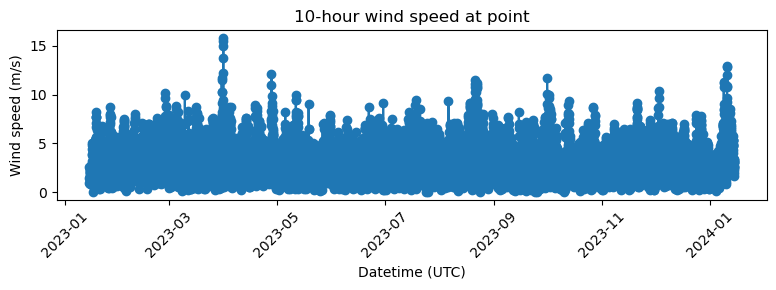

In [13]:
if not df_ten.empty:
    plt.figure(figsize=(8, 3))
    x = df_ten['datetime'].to_numpy()
    y = df_ten['wind_speed_100m'].to_numpy()
    plt.plot(x, y, marker='o')
    plt.title('10-hour wind speed at point')
    plt.ylabel('Wind speed (m/s)')
    plt.xlabel('Datetime (UTC)')
    plt.xticks(rotation=45)
    plt.tight_layout()


In [40]:
df_ten

,datetime,longitude,latitude,u_component_of_wind_100m,v_component_of_wind_100m,wind_speed_100m
0,2023-01-15 00:00:00+00:00,-104.900767,39.656128,-2.541130,-0.356517,2.566017
1,2023-01-15 01:00:00+00:00,-104.900767,39.656128,-0.929029,-0.332791,0.986835
2,2023-01-15 02:00:00+00:00,-104.900767,39.656128,0.923102,-1.078370,1.419507
3,2023-01-15 03:00:00+00:00,-104.900767,39.656128,1.505353,-1.037294,1.828132
4,2023-01-15 04:00:00+00:00,-104.900767,39.656128,1.291811,-0.817613,1.528812
...,...,...,...,...,...,...
8755,2024-01-14 19:00:00+00:00,-104.900767,39.656128,-2.294500,0.299302,2.313939
8756,2024-01-14 20:00:00+00:00,-104.900767,39.656128,-2.172307,1.578649,2.685340
8757,2024-01-14 21:00:00+00:00,-104.900767,39.656128,-2.832289,1.156573,3.059333
8758,2024-01-14 22:00:00+00:00,-104.900767,39.656128,-2.831169,0.948012,2.985674
